# Heart Disease Report - Group 41

### Introduction:

Heart Disease is a term used to describe many different conditions that affect the heart. The severity of a heart disease can vary greatly in extremity, and curability. Some examples of heart disease include : heart attack,  high blood pressure, stroke, and coronary heart disease. Heart diseases are often genetic, and there are many predictors that can be used by doctors and researchers to identify if a patient is at risk. This has become as relevant as ever, as it is estimated that approximately 17.9 million people in the world die each year from a heart disease. 

The question we want to answer is using cholesterol level, blood pressure, heart rate and age to predict whether a person would have a heart disease.

We are using a database with 13 variables, of which describe information about the 303 patients from Cleveland, Ohio. (For the result for diagnosis of heart disease, 0 means disease is not present while 1-4 means disease is present). Some of the variables include missing values, which are identified from the database site.  The dataset has been referenced in plenty of classification and regression papers.


### Preliminary exploratory data analysis:

In [60]:
### loading in the libraries
set.seed(1234567)
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("gridExtra")
library(gridExtra)
install.packages("kknn")
options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



**1. Load data from git hub and rename columns**

In [2]:
# URL from github to read the data
url <- "https://raw.githubusercontent.com/GloriaYi/dsci-100-2023w1-group41/main/processed.cleveland.data"

In [3]:
# rename the columns 
col_names <- c("age", "sex", "cp", "resting_blood_pressure", "cholesterol",
               "fasting_blood_sugar", "restecg", "maximum_heart_rate_achieved", 
               "exercise_induced_angina", "ST_depression_induced_by_excercise_relative_to_rest", 
               "slope", "number_of_major_vessels", "thal", "diagnosis_of_heart_disease")

# reading the data
raw_data <- read_csv (url, col_name = col_names)
raw_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): number_of_major_vessels, thal
dbl (12): age, sex, cp, resting_blood_pressure, cholesterol, fasting_blood_s...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,resting_blood_pressure,cholesterol,fasting_blood_sugar,restecg,maximum_heart_rate_achieved,exercise_induced_angina,ST_depression_induced_by_excercise_relative_to_rest,slope,number_of_major_vessels,thal,diagnosis_of_heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


Since the missing values in this data set is represented by "?", we want to change it to "NA" first so that we can use the build in function to calculate how many missing data we have. As shown below, our raw data set contains 6 missing values.

In [4]:
# changing the missing data represented by "?" to "NA"
raw_data[raw_data == "?"] <- NA

na_count <- sum(is.na(raw_data))
na_count

[1] 6

Then we filter out all other columns, leaving only ```age```, ```resting_blood_pressure```, ```cholesterol```, ```maximum_heart_rate_achieved``` and ```diagnosis_of_heart_disease```. The first 4 columns are the predictors and the last column is response variable.

In [5]:
# keeping only the columns we need
keep_data <- raw_data |>
    select (age, resting_blood_pressure, cholesterol, maximum_heart_rate_achieved, diagnosis_of_heart_disease)
keep_data

age,resting_blood_pressure,cholesterol,maximum_heart_rate_achieved,diagnosis_of_heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,145,233,150,0
67,160,286,108,2
67,120,229,129,1
⋮,⋮,⋮,⋮,⋮
57,130,131,115,3
57,130,236,174,1
38,138,175,173,0


In [6]:
# treating diagnosis_of_heart_disease as factor 
heart_disease <- keep_data |>
    mutate (diagnosis_of_heart_disease = as_factor (diagnosis_of_heart_disease))
    

# changing ? to NA
heart_disease[heart_disease == "?"] <- NA
n <- sum(is.na(heart_disease))
n

heart_disease

[1] 0

age,resting_blood_pressure,cholesterol,maximum_heart_rate_achieved,diagnosis_of_heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,0
67,160,286,108,2
67,120,229,129,1
⋮,⋮,⋮,⋮,⋮
57,130,131,115,3
57,130,236,174,1
38,138,175,173,0


We can see that there are no missing values anymore, so we proceed to the next step

In the description of the data set, the researchers did not specify whether categories 1 to 4 refer to any subcategories (e.g. seriousness of the disease). Instead, they just stated that 0 represent heart disease is not present and 1 to 4 represent heart disease is present, so we decided to simply change the levels in factor `diagnosis_of_heart_disease` to 'Yes' and 'No'.

In [7]:
# change level 0 to No and level 1-4 to Yes, change the new variable to a factor and drop the original column
heart_disease <- heart_disease |>
    mutate(diagnosis = case_when(
    diagnosis_of_heart_disease == "0" ~ 'No',
    TRUE ~ 'Yes')) |>
    mutate(diagnosis = as_factor(diagnosis)) |>
    select(-diagnosis_of_heart_disease)
heart_disease

# check the proportion of presense and non-presense of heart disease in this data set
proportion <- heart_disease |>
    group_by(diagnosis) |>
    summarize(n = n(), percentage = n / nrow(heart_disease))

proportion

age,resting_blood_pressure,cholesterol,maximum_heart_rate_achieved,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,No
67,160,286,108,Yes
67,120,229,129,Yes
⋮,⋮,⋮,⋮,⋮
57,130,131,115,Yes
57,130,236,174,Yes
38,138,175,173,No


diagnosis,n,percentage
<fct>,<int>,<dbl>
No,164,0.5412541
Yes,139,0.4587459


**2. Split data into training set and testing set**

In [8]:
# splitting the data into training and testing
heart_disease_split <- initial_split (heart_disease, prop = 0.75, strata = diagnosis)
heart_disease_train <- training (heart_disease_split)
heart_disease_test <- testing (heart_disease_split)


In [9]:
# the count of each factor of heart disease
heart_disease_count <- heart_disease_train |>
    group_by (diagnosis) |>
    summarize (count = n())

heart_disease_count

# the average of the variables we will be using
heart_disease_averages <- heart_disease_train |>
  select(age: maximum_heart_rate_achieved) |>
  map_dfr(mean)

heart_disease_averages

diagnosis,count
<fct>,<int>
No,123
Yes,104


age,resting_blood_pressure,cholesterol,maximum_heart_rate_achieved
<dbl>,<dbl>,<dbl>,<dbl>
54.51982,131.9692,249.9383,149.9163


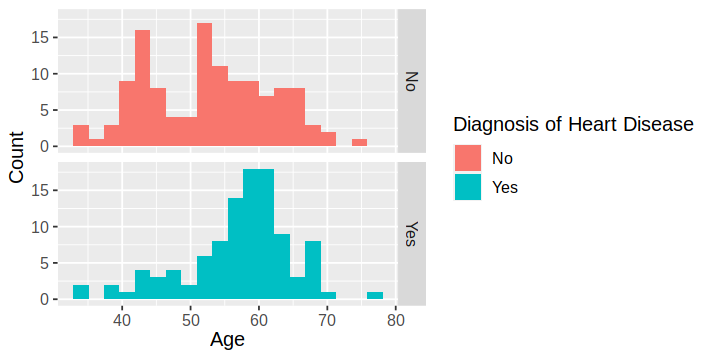

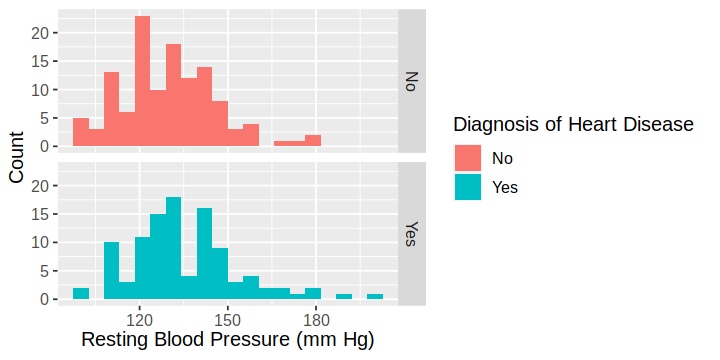

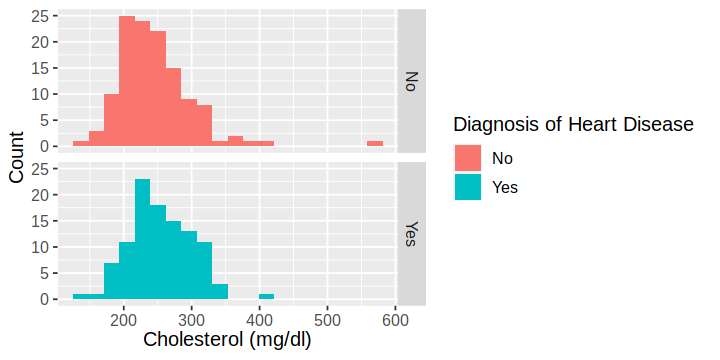

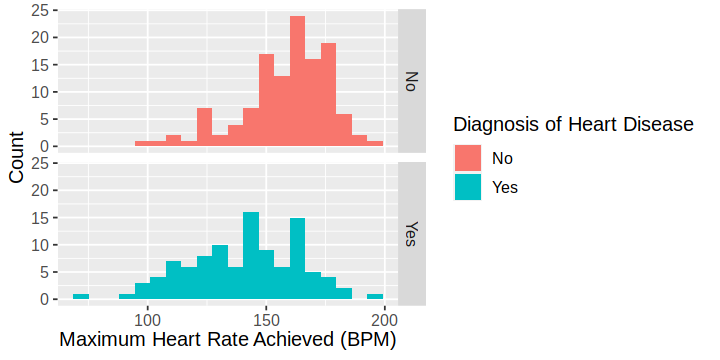

In [41]:
# visualizing the data 
options(repr.plot.width = 6, repr.plot.height = 3)

heart_disease_age <- heart_disease_train |>
    ggplot (aes (x = age, fill = as_factor(diagnosis))) +
  geom_histogram(bins = 20) +
  facet_grid(rows = vars(diagnosis)) +
    labs(x = "Age", 
       y = "Count", 
       fill = "Diagnosis of Heart Disease") +
  theme(text = element_text(size = 12))

heart_disease_age

heart_disease_resting_blood_pressure <- heart_disease_train |>
    ggplot (aes (x = resting_blood_pressure, fill = as_factor(diagnosis))) +
  geom_histogram(bins = 20) +
  facet_grid(rows = vars(diagnosis)) +
    labs(x = "Resting Blood Pressure (mm Hg)", 
       y = "Count", 
       fill = "Diagnosis of Heart Disease") +
  theme(text = element_text(size = 12))

heart_disease_resting_blood_pressure

heart_disease_cholesterol <- heart_disease_train |>
    ggplot (aes (x = cholesterol, fill = as_factor(diagnosis))) +
  geom_histogram(bins = 20) +
  facet_grid(rows = vars(diagnosis)) +
    labs(x = "Cholesterol (mg/dl)", 
       y = "Count", 
       fill = "Diagnosis of Heart Disease") +
  theme(text = element_text(size = 12))

heart_disease_cholesterol

heart_disease_maximum_heart_rate_achieved <- heart_disease_train |>
    ggplot (aes (x = maximum_heart_rate_achieved, fill = as_factor(diagnosis))) +
  geom_histogram(bins = 20) +
  facet_grid(rows = vars(diagnosis)) +
    labs(x = "Maximum Heart Rate Achieved (BPM)", 
       y = "Count", 
       fill = "Diagnosis of Heart Disease") +
  theme(text = element_text(size = 12))

heart_disease_maximum_heart_rate_achieved

### Method and Results

**Methods:**

We would use 4 columns including: cholesterol, resting_blood_pressure, maximum_heart_rate_achieved and age.
We selected these 4 variables due to a combination of prior knowledge, as well as reading through databases and articles regarding risk factors for heart disease. We came to the conclusion that cholesterol, blood pressure, maximum heart rate achieved (fitness) and age were among the greatest indicators for risk of heart disease.  Therefore it felt appropriate to base our prediction model on these 4 factors, providing a more simplified prediction, opposed to using all 13 variables. 
We will split the data into different subsets and use cross validation to train the model. We then use different k values with the classifier to evaluate which k value gives us the highest accuracy. After that we will use the k-nearest neighbors method to predict the classification of a new observation - if the patient has heart disease.
For visualization, we will generate a plot for all the data points and the unknown classifications.
We will also generate a plot to visualize the relationship between accuracy estimation and different k values


**Expected outcomes and significance:**

We expect to see patients that are high in blood pressure / cholesterol level / age / heart rate have a higher risk of getting heart disease. We also want to examine how well our classifier works on predicting if the patient would have heart disease. If the classifier could understand the relationship between the predictors and the heart disease diagnosis well enough, we could get a more accurate result for prediction. This might be beneficial to patients at risk of potential heart disease because their condition might not be as severe if intervened early. The attempt with using k-nearest neighbors algorithm to do prediction acts as a foundation to explore classification. Some future question might be: whether all these variables contribute equally in prediction of presence of heart disease? Is there a better model than knn for prediction?

**2. Find the k value that gives the highest accuracy**

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
19,accuracy,binary,0.6741414,5,0.01656049,Preprocessor1_Model19
20,accuracy,binary,0.6741414,5,0.01656049,Preprocessor1_Model20
11,accuracy,binary,0.6654458,5,0.01601059,Preprocessor1_Model11
⋮,⋮,⋮,⋮,⋮,⋮,⋮
6,accuracy,binary,0.5903513,5,0.02941499,Preprocessor1_Model06
3,accuracy,binary,0.5595257,5,0.03262453,Preprocessor1_Model03
4,accuracy,binary,0.5595257,5,0.03262453,Preprocessor1_Model04


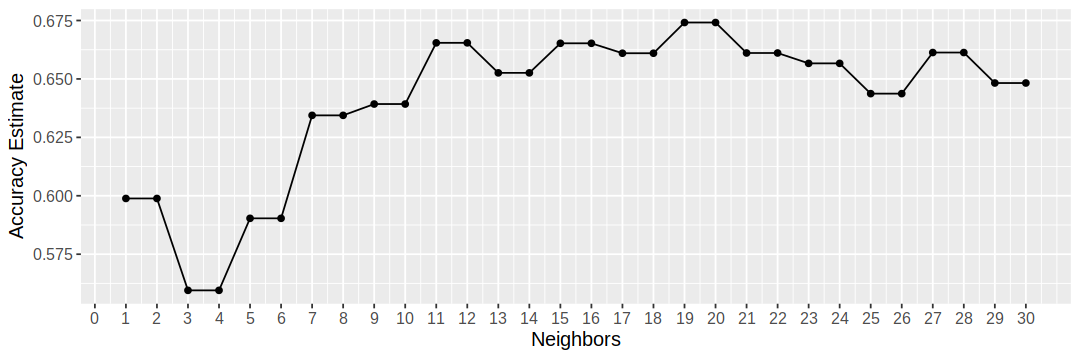

In [12]:
# create a 5 fold validation for data
heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = diagnosis)

# create a subset of k values
k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

# create a recipe that uses all other variable except diagnosis as predictors, scale all predictors
heart_disease_recipe <- recipe(diagnosis ~ ., 
                        data = heart_disease_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# create a k-nearest-neighbor model specification that tries different k values with tune()
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# create a workflow with recipe and model specification
knn_results <- workflow() |>
  add_recipe(heart_disease_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_disease_vfold, grid = k_vals) |>
  collect_metrics() 

# list the accuracy for different k values in descending order
accuracies <- knn_results |>
  filter(.metric == "accuracy") |>
    arrange(by = desc(mean))

accuracies

# create a plot to show which k values to take
options(repr.plot.width = 9)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  scale_x_continuous(breaks = seq(from = 0, to = 30, by = 1)) +
  theme(text = element_text(size = 12))

accuracy_vs_k
# k = 19

Since k = 19 gives us the highest accuracy, and it is odd so that we would not end up with a tie in majority of data points in classification. So e would use k = 19 to create a new model specification and set up a new workflow to fit the data.

**3. Train classifier with k nearest neighbor algorithm**

In [13]:
heart_disease_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(heart_disease_recipe) |>
  add_model(heart_disease_spec) |>
  fit(data = heart_disease_train)

knn_fit

**4. Perform prediction on testing data set and determine accuracy**

In [15]:
# use classifier to do prediction on testing data
predictions <- predict(knn_fit, heart_disease_test) |>
        bind_cols(heart_disease_test)
predictions

# calculate the accuracy on its prediction
heart_disease_metrics <- predictions |>
        metrics(truth = diagnosis,estimate = .pred_class) |>
        filter(.metric == "accuracy")
heart_disease_metrics

confusion <- predictions |>
             conf_mat(truth = diagnosis, estimate = .pred_class)
confusion

.pred_class,age,resting_blood_pressure,cholesterol,maximum_heart_rate_achieved,diagnosis
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
No,37,130,250,187,No
No,41,130,204,172,No
No,53,140,203,155,Yes
⋮,⋮,⋮,⋮,⋮,⋮
Yes,61,140,207,138,Yes
No,44,120,169,144,Yes
No,45,110,264,132,Yes


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6710526


          Truth
Prediction No Yes
       No  29  13
       Yes 12  22

The precision is 64.7 %. The recall is 62.9%. In the application as a diagnosis tool, it is important to accurately classify patients with a true heart disease as such (it is less severe if a patient without a heart disease is classified to have a disease as more investigations will give the correct result). The prediction model should be optimized regarding high recall.

Because more than three predictors were used in this classification problem, easy visualization of the results is difficult. In the following the result of predicting the testing data is depicted in terms of a histogram for each predictor and scatter plots for the combination of two predictors. However, it appears that there is no clear pattern regarding the distribution of incorrectly classified observations.

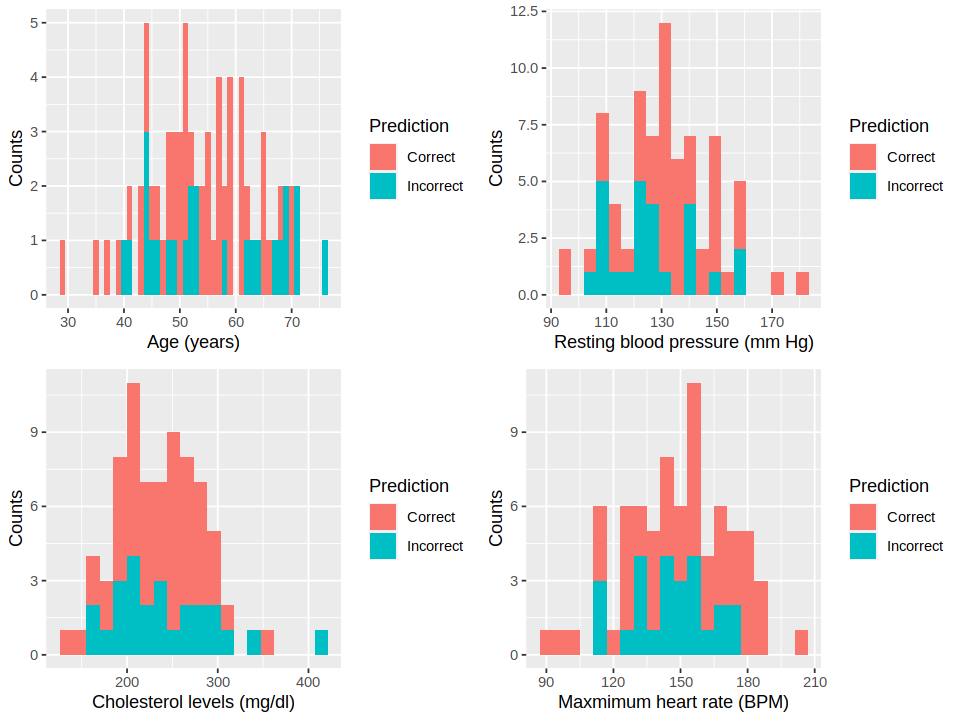

In [66]:
predictions_vis <- predictions |>
    mutate(pred_correct = case_when(
    diagnosis == .pred_class ~ 'Correct',
    TRUE ~ 'Incorrect')) |>
    mutate(pred_correct = as_factor(pred_correct))

options(repr.plot.width = 8, repr.plot.height = 6)
plot_age_pred <- predictions_vis |>
    ggplot(aes(age, fill = pred_correct)) +
    geom_histogram(binwidth = 1) +
    labs(x = "Age (years)", y = "Counts", fill = "Prediction")

plot_resting_blood_pressure_pred <- predictions_vis |>
    ggplot(aes(resting_blood_pressure, fill = pred_correct)) +
    geom_histogram(bins = 20) +
    labs(x = "Resting blood pressure (mm Hg)", y = "Counts", fill = "Prediction")

plot_cholesterol_pred <- predictions_vis |>
    ggplot(aes(cholesterol, fill = pred_correct)) +
    geom_histogram(bins = 20) +
    labs(x = "Cholesterol levels (mg/dl)", y = "Counts", fill = "Prediction")


plot_maximum_heart_rate_achieved_pred <- predictions_vis |>
    ggplot(aes(maximum_heart_rate_achieved, fill = pred_correct)) +
    geom_histogram(bins = 20) +
    labs(x = "Maxmimum heart rate (BPM)", y = "Counts", fill = "Prediction")

grid.arrange(plot_age_pred, 
             plot_resting_blood_pressure_pred, 
             plot_cholesterol_pred,
             plot_maximum_heart_rate_achieved_pred, 
             nrow = 2)

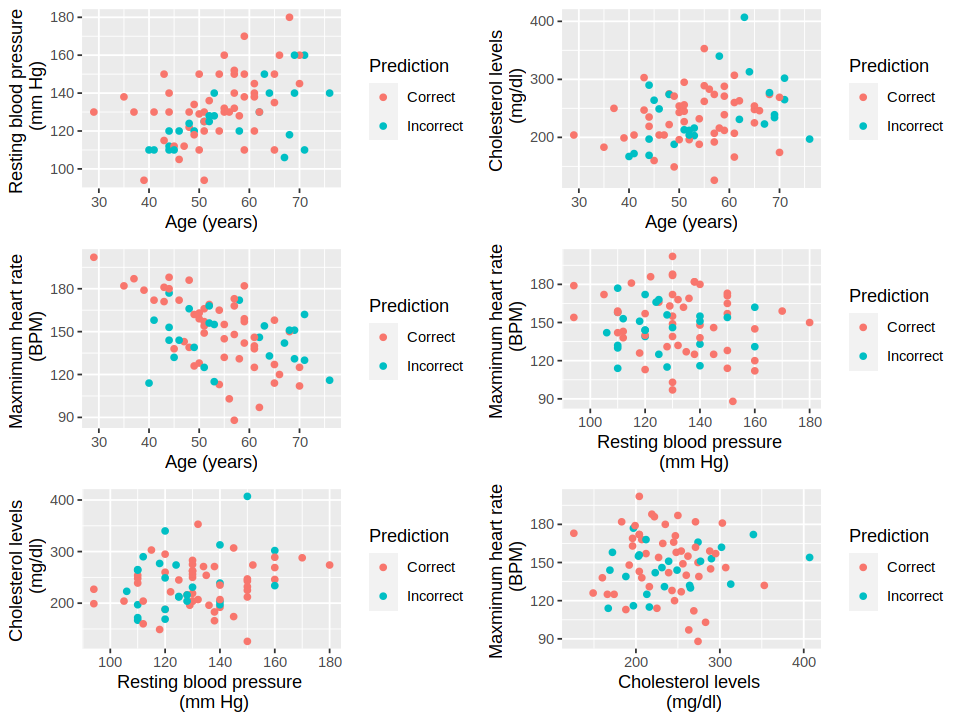

In [75]:
options(repr.plot.width = 8, repr.plot.height = 6)

plot_age_pres_1 <- predictions_vis |>
    ggplot(aes(x = age, y = resting_blood_pressure, color = pred_correct)) +
    geom_point() +
    labs(x = "Age (years)", y = "Resting blood pressure \n (mm Hg)", color = "Prediction")

plot_age_col_2 <- predictions_vis |>
    ggplot(aes(x = age, y = cholesterol, color = pred_correct)) +
    geom_point() +
    labs(x = "Age (years)", y = "Cholesterol levels \n (mg/dl)", color = "Prediction")

plot_age_rate_3 <- predictions_vis |>
    ggplot(aes(x = age, y = maximum_heart_rate_achieved, color = pred_correct)) +
    geom_point() +
    labs(x = "Age (years)", y = "Maxmimum heart rate \n (BPM)", color = "Prediction")

plot_pres_rate_4 <- predictions_vis |>
    ggplot(aes(x = resting_blood_pressure, y = maximum_heart_rate_achieved, color = pred_correct)) +
    geom_point() +
    labs(x = "Resting blood pressure \n (mm Hg)", y = "Maxmimum heart rate \n (BPM)", color = "Prediction")

plot_col_pres_5 <- predictions_vis |>
    ggplot(aes(y = cholesterol, x = resting_blood_pressure, color = pred_correct)) +
    geom_point() +
    labs(y = "Cholesterol levels \n (mg/dl)", x = "Resting blood pressure \n (mm Hg)", color = "Prediction")

plot_col_rate_6 <- predictions_vis |>
    ggplot(aes(x = cholesterol, y = maximum_heart_rate_achieved, color = pred_correct)) +
    geom_point() +
    labs(x = "Cholesterol levels \n (mg/dl)", y = "Maxmimum heart rate \n (BPM)", color = "Prediction")

layout_matrix_c = 
grid.arrange(grobs = list(plot_age_pres_1,
             plot_age_col_2,
             plot_age_rate_3,
             plot_pres_rate_4,
             plot_col_pres_5,
             plot_col_rate_6),
             ncol = 2)